### Workshop series, Koç University, Turkey, 11-12 April 2023

##  [Introduction to Computational Social Science methods with Python](https://socialcomquant.ku.edu.tr/intro-to-css-methods-with-python/)

# Workshop 2: Introduction to network analysis with Python - Part I

**Description**: Computational Social Science is often concerned with the traces of human behavior like those left by uses of social media, messaging services, or cell phones. Such digital behavioral data is genuinely relational and can, therefore, be studied using the formal techniques of network analysis. The basic units of networks called nodes can be actors (e.g., users), communicative symbols (e.g., hashtags), or even transactions (e.g., tweets). By focusing on the edges (relations) among nodes, network analysis is capable of creating insights that are not possible by merely doing statistics on the nodes and their attributes. In the workshop, we will give an introduction to how network data should be organized, how networks can be created in Python, and how they can be analyzed on three levels. On the micro level, we will introduce centrality analysis which results in numerical descriptions of nodes. On the meso level, we will introduce community detection, which results in sets of nodes that form groups or clusters. On the macro level, we will introduce measures that describe homophily, assortativity of, the network in its entirety. We will be using network data from the Copenhagen Networks Study, which describes four different types of social relations among students over time. The workshop will alternate between live-coding demonstrations and periods in which participants apply that knowledge in context, both using Jupyter Notebooks. The software we will be using is NetworkX, a standard Python library that is simple to understand, provides a breadth of options and has a large user community.

**Target group**: Undergraduate, master students, doctoral candidates, and experienced researchers who want to get introduced to the practice of Computational Social Science.

**Requirements**: Participants are expected to know the basics of Python and have at least some experience using it. For the workshops, participants should bring a running system on which they can execute Jupyter Notebooks. We will be using Python 3.9 and several standard libraries that are part of the Anaconda 2022.10 distribution or can be installed on top of that. A list of libraries and versions of these libraries that participants should import will be circulated before the workshops. We recommend that participants install Anaconda 2022.10. Feel free to also work in a cloud-like Google Colab. Consult [this link](https://github.com/gesiscss/css_methods_python/blob/main/a_introduction/1_computing_environment.ipynb) for more detailed instructions on how to set up your computing environment.

**Lecturers**: Dr. Haiko Lietz is a postdoctoral researcher in the Computational Social Science department at GESIS - Leibniz Institute for the Social Sciences. His research interests are in computational sociology, network science, and complexity science. Dr. N. Gizem Bacaksizlar Turbic is a postdoctoral researcher in the Computational Social Science departments at RWTH Aachen University and GESIS - Leibniz Institute for the Social Sciences. Her research areas include complex adaptive systems and social and political networks.

## Documentation of Networkx 2.8.4

https://networkx.org/documentation/networkx-2.8.4/reference/index.html

## Network construction

### Constructing from scratch

In [1]:
import networkx as nx
nx.__version__

'3.0'

In [2]:
G = nx.Graph()

In [3]:
D = nx.DiGraph()

In [4]:
G.add_node(5)

In [5]:
G.add_nodes_from(['pretty', 13])

In [6]:
G.nodes()

NodeView((5, 'pretty', 13))

In [7]:
G.add_edge('pretty', 13)

In [8]:
G.add_edges_from([('pretty', 13), ('ruby', 0)])

In [9]:
G.edges()

EdgeView([('pretty', 13), ('ruby', 0)])

In [10]:
G.nodes()

NodeView((5, 'pretty', 13, 'ruby', 0))

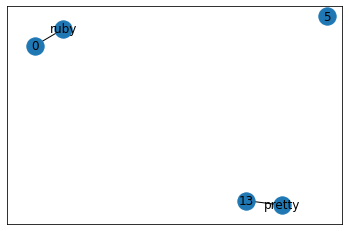

In [11]:
nx.draw_networkx(G, with_labels = True)

### Constructing from Pandas dataframes

In [12]:
import pandas as pd
pd.__version__

'1.2.4'

#### Copenhagen Networks Study interaction data

In [13]:
edgelist_sms = pd.read_csv('data/sms.csv')
edgelist_sms.sort_values('sender').head()

,timestamp,sender,recipient
16825,1613876,0,208
34,3629,0,512
1745,169370,0,512
36,4602,0,512
1802,176949,0,512


In [14]:
with open('data/sms.README', 'r') as f:
    print(f.read())

column names:
	- timestamp
	- sender
	- recipient



In [15]:
import matplotlib.pyplot as plt

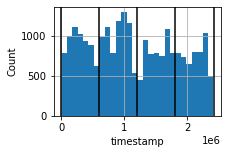

In [16]:
plt.figure(figsize=[3, 2])
edgelist_sms['timestamp'].hist(bins=28)
for i in range(5):
    plt.axvline(x=7*24*60*60*i, color='black') #days*hours*min*sec
plt.xlabel('timestamp')
plt.ylabel('Count')
plt.show()

#### Text messaging network

In [17]:
D_sms = nx.from_pandas_edgelist(
    df = edgelist_sms, 
    source = 'sender', 
    target = 'recipient', 
    create_using = nx.DiGraph
)
D_sms

In [18]:
D_sms.edges()

OutEdgeView([(370, 512), (512, 370), (512, 0), (512, 299), (512, 55), (512, 36), (512, 211), (512, 348), (512, 46), (0, 512), (0, 208), (137, 136), (137, 176), (137, 599), (137, 25), (137, 454), (136, 137), (136, 108), (136, 73), (136, 654), (278, 335), (278, 31), (335, 414), (335, 278), (299, 237), (299, 512), (299, 133), (299, 144), (299, 744), (237, 299), (237, 133), (663, 519), (519, 85), (519, 663), (300, 301), (300, 371), (300, 743), (300, 100), (301, 300), (301, 69), (301, 186), (301, 37), (47, 19), (47, 449), (47, 46), (19, 47), (19, 595), (202, 697), (697, 202), (454, 244), (454, 25), (454, 137), (244, 454), (244, 766), (244, 25), (687, 310), (687, 265), (687, 540), (310, 687), (310, 143), (310, 540), (310, 265), (279, 617), (617, 279), (617, 391), (617, 368), (218, 382), (218, 100), (218, 772), (382, 218), (382, 234), (611, 146), (611, 176), (611, 268), (611, 472), (146, 611), (146, 458), (146, 145), (146, 176), (31, 76), (31, 278), (31, 399), (76, 588), (76, 31), (176, 611),

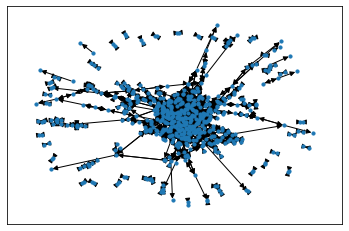

In [19]:
nx.draw_networkx(G=D_sms, node_size=10, with_labels = False)

#### Aggregated text messaging network

In [20]:
def aggregate_edges(df, time, source, target, weight, time_zero, window_size, inclusive, fun):
    '''
    Aggregates edges from a time-stamped edge list according to an aggregation function.
    
    Parameters:
        df : Pandas DataFrame
            Time-stamped edgelist.
        time : String
            Name of the column in df which contains the timestamp.
        source : String
            Name of the column in df which contains the source node.
        target : String
            Name of the column in df which contains the target node.>
        weight : String or None
            Name of the column in df which contains the edge weights. If None, a column with unit edge weights will be created.
        time_zero : String or numerical
            Time where aggregation begins.
        window_size : String or numerical
            Size of the time window used for aggregation.
        inclusive : {'both', 'neither', 'left', 'right'}
            Include boundaries. Whether to set each bound as closed or open.
        fun : {'max', 'sum', 'mean'}
            Aggregation method. Either the maximum edge weight is used, weights are summed, or weights are averaged.
    
    Returns:
        Aggregated edge list consisting of a node pair and a weight column.
    '''
    if weight == None:
        weight = 'weight'
        df[weight] = 1
    if fun == 'max':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).max().reset_index()[[source, target, weight]]
    if fun == 'sum':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).sum().reset_index()[[source, target, weight]]
    if fun == 'mean':
        df_agg = df[df[time].between(left=time_zero, right=time_zero+window_size, inclusive=inclusive)].groupby([source, target]).mean().reset_index()[[source, target, weight]]
    return df_agg

In [21]:
edgelist_sms_week1 = aggregate_edges(
    df = edgelist_sms, 
    time = 'timestamp', 
    source = 'sender', 
    target = 'recipient', 
    weight = None, 
    time_zero = 0, 
    window_size = 604800, 
    inclusive = 'left', 
    fun = 'sum'
)
edgelist_sms_week1.head()

,sender,recipient,weight
0,0,512,34
1,1,345,2
2,3,49,6
3,3,357,23
4,4,221,2


In [22]:
D_sms_week1 = nx.from_pandas_edgelist(
    df = edgelist_sms_week1, 
    source = 'sender', 
    target = 'recipient', 
    edge_attr = 'weight', 
    create_using = nx.DiGraph
)
D_sms_week1

In [23]:
D_sms_week1.edges(data=True)

OutEdgeDataView([(0, 512, {'weight': 34}), (512, 0, {'weight': 38}), (512, 36, {'weight': 1}), (512, 55, {'weight': 20}), (512, 299, {'weight': 82}), (512, 370, {'weight': 6}), (1, 345, {'weight': 2}), (345, 1, {'weight': 1}), (3, 49, {'weight': 6}), (3, 357, {'weight': 23}), (49, 3, {'weight': 4}), (49, 48, {'weight': 15}), (49, 171, {'weight': 7}), (357, 3, {'weight': 21}), (357, 49, {'weight': 1}), (4, 221, {'weight': 2}), (4, 266, {'weight': 5}), (4, 344, {'weight': 4}), (4, 424, {'weight': 1}), (221, 263, {'weight': 1}), (221, 324, {'weight': 17}), (266, 4, {'weight': 6}), (266, 424, {'weight': 3}), (266, 785, {'weight': 1}), (344, 4, {'weight': 3}), (344, 100, {'weight': 1}), (344, 221, {'weight': 2}), (344, 670, {'weight': 8}), (424, 266, {'weight': 4}), (424, 348, {'weight': 2}), (424, 645, {'weight': 3}), (424, 785, {'weight': 1}), (5, 802, {'weight': 11}), (802, 5, {'weight': 8}), (6, 27, {'weight': 14}), (27, 6, {'weight': 5}), (27, 371, {'weight': 7}), (27, 616, {'weight': 

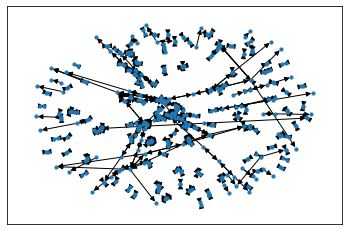

In [24]:
nx.draw_networkx(G=D_sms_week1, node_size=10, with_labels = False)

#### Node attributes

{0: 'male', 1: 'female', 2: 'unknown'}

In [25]:
nodelist = pd.read_csv('data/nodelist.csv')
nodelist.tail()

,user,sex
840,845,0
841,846,0
842,847,1
843,848,2
844,850,2


In [26]:
nodelist = nodelist.set_index('user', drop=False)
nodelist.tail()

,user,sex
user,,
845,845,0
846,846,0
847,847,1
848,848,2
850,850,2


In [27]:
for v in D_sms_week1.nodes:
    D_sms_week1.nodes[v]['sex'] = nodelist.loc[v, 'sex']

In [28]:
D_sms_week1.nodes(data=True)

NodeDataView({0: {'sex': 0}, 512: {'sex': 1}, 1: {'sex': 2}, 345: {'sex': 0}, 3: {'sex': 0}, 49: {'sex': 0}, 357: {'sex': 1}, 4: {'sex': 0}, 221: {'sex': 0}, 266: {'sex': 0}, 344: {'sex': 0}, 424: {'sex': 0}, 5: {'sex': 0}, 802: {'sex': 0}, 6: {'sex': 1}, 27: {'sex': 0}, 8: {'sex': 0}, 419: {'sex': 0}, 557: {'sex': 1}, 9: {'sex': 0}, 669: {'sex': 0}, 12: {'sex': 0}, 13: {'sex': 0}, 492: {'sex': 0}, 658: {'sex': 0}, 18: {'sex': 0}, 276: {'sex': 0}, 488: {'sex': 0}, 570: {'sex': 0}, 19: {'sex': 0}, 47: {'sex': 0}, 595: {'sex': 0}, 20: {'sex': 0}, 21: {'sex': 1}, 23: {'sex': 0}, 51: {'sex': 1}, 24: {'sex': 0}, 82: {'sex': 0}, 371: {'sex': 1}, 616: {'sex': 0}, 28: {'sex': 0}, 317: {'sex': 0}, 31: {'sex': 2}, 76: {'sex': 0}, 278: {'sex': 0}, 33: {'sex': 0}, 242: {'sex': 0}, 35: {'sex': 0}, 43: {'sex': 0}, 36: {'sex': 1}, 37: {'sex': 0}, 401: {'sex': 0}, 39: {'sex': 0}, 118: {'sex': 0}, 257: {'sex': 2}, 331: {'sex': 2}, 457: {'sex': 0}, 545: {'sex': 1}, 622: {'sex': 1}, 707: {'sex': 1}, 46: 

#### Components

Graph-theoretically, each isolated node as well as the main part is a subgraph in which the nodes are reachable via edges. Such a subgraph is called a connected component. 

In [29]:
nx.is_weakly_connected(G=D_sms_week1)

False

In [30]:
nx.number_weakly_connected_components(G=D_sms_week1)

92

In [31]:
cc_sms_week1 = nx.weakly_connected_components(D_sms_week1)
cc_sms_week1

<generator object weakly_connected_components at 0x000001EA10FED7B0>

In [32]:
next(cc_sms_week1)

{0,
 4,
 6,
 27,
 36,
 37,
 39,
 52,
 55,
 64,
 69,
 70,
 90,
 91,
 97,
 100,
 104,
 108,
 109,
 118,
 121,
 133,
 136,
 137,
 141,
 145,
 146,
 151,
 152,
 157,
 158,
 165,
 166,
 176,
 177,
 190,
 194,
 204,
 218,
 221,
 234,
 235,
 236,
 237,
 257,
 263,
 266,
 268,
 272,
 275,
 288,
 289,
 294,
 297,
 299,
 300,
 301,
 308,
 312,
 324,
 331,
 333,
 344,
 348,
 358,
 370,
 371,
 373,
 374,
 382,
 401,
 405,
 415,
 424,
 457,
 458,
 465,
 472,
 485,
 486,
 512,
 521,
 537,
 545,
 568,
 569,
 578,
 598,
 611,
 616,
 619,
 622,
 645,
 657,
 670,
 688,
 707,
 743,
 752,
 772,
 785,
 798,
 800}

In [33]:
cc_sms_week1 = sorted(nx.weakly_connected_components(D_sms_week1), key=len, reverse=True)
cc_sms_week1

[{0,
  4,
  6,
  27,
  36,
  37,
  39,
  52,
  55,
  64,
  69,
  70,
  90,
  91,
  97,
  100,
  104,
  108,
  109,
  118,
  121,
  133,
  136,
  137,
  141,
  145,
  146,
  151,
  152,
  157,
  158,
  165,
  166,
  176,
  177,
  190,
  194,
  204,
  218,
  221,
  234,
  235,
  236,
  237,
  257,
  263,
  266,
  268,
  272,
  275,
  288,
  289,
  294,
  297,
  299,
  300,
  301,
  308,
  312,
  324,
  331,
  333,
  344,
  348,
  358,
  370,
  371,
  373,
  374,
  382,
  401,
  405,
  415,
  424,
  457,
  458,
  465,
  472,
  485,
  486,
  512,
  521,
  537,
  545,
  568,
  569,
  578,
  598,
  611,
  616,
  619,
  622,
  645,
  657,
  670,
  688,
  707,
  743,
  752,
  772,
  785,
  798,
  800},
 {61,
  128,
  149,
  208,
  256,
  274,
  285,
  350,
  409,
  422,
  448,
  491,
  553,
  632,
  786,
  845},
 {23, 51, 75, 129, 154, 179, 193, 282, 342, 372, 455, 720, 812},
 {12, 13, 88, 147, 254, 492, 505, 532, 564, 572, 658, 699},
 {173, 183, 211, 412, 466, 561, 631, 685, 689},
 {28, 215, 

In [34]:
D_sms_week1_lcc = D_sms_week1.subgraph(nodes=cc_sms_week1[0])
D_sms_week1_lcc

## Network visualization

In [35]:
pos_sms_week1_lcc = nx.spring_layout(G=D_sms_week1_lcc, weight=None)
pos_sms_week1_lcc

{0: array([0.21675257, 0.19725877]),
 512: array([0.17728155, 0.25149561]),
 4: array([0.40198524, 0.10743306]),
 6: array([-0.43843039, -0.04884154]),
 521: array([ 0.06813069, -0.15303278]),
 537: array([ 0.02082425, -0.62056035]),
 27: array([-0.36429897, -0.04892877]),
 545: array([-0.92032385, -0.65415812]),
 36: array([0.1292042 , 0.40726952]),
 37: array([0.11474974, 0.45690695]),
 39: array([-0.37221841,  0.23223368]),
 52: array([ 0.47089039, -0.38438638]),
 55: array([0.16686802, 0.26469544]),
 568: array([ 0.07604938, -0.23171563]),
 569: array([0.05137434, 0.76784003]),
 64: array([ 0.11056749, -0.51347898]),
 578: array([ 0.05591052, -0.01787405]),
 69: array([0.08039047, 0.30733123]),
 70: array([-1.        , -0.04402308]),
 598: array([-0.74075899, -0.15280896]),
 90: array([ 0.07072466, -0.43368392]),
 91: array([ 0.09723743, -0.4778195 ]),
 97: array([ 0.33775351, -0.22756444]),
 611: array([0.07440749, 0.11804412]),
 100: array([ 0.10867459, -0.19146446]),
 104: array

In [36]:
pos_sms_week1_lcc = nx.kamada_kawai_layout(G=D_sms_week1_lcc, weight=None)

In [37]:
nx.set_node_attributes(G=D_sms_week1_lcc, values=pos_sms_week1_lcc, name='pos')

In [38]:
node_color_sms_week1_lcc = list(nx.get_node_attributes(G=D_sms_week1_lcc, name='sex').values())
node_color_sms_week1_lcc[:5]

[0, 1, 0, 1, 1]

In [39]:
import numpy as np

In [40]:
width_sms_week1_lcc = [np.log(w) + 1 for w in nx.get_edge_attributes(G=D_sms_week1_lcc, name='weight').values()]
width_sms_week1_lcc[:5]

[4.526360524616162,
 4.637586159726386,
 1.0,
 3.995732273553991,
 5.406719247264253]

In [41]:
import os
directory = 'results'
if not os.path.exists(directory):
    os.makedirs(directory)

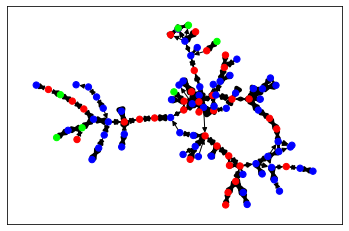

In [42]:
nx.draw_networkx(
    G = D_sms_week1_lcc, 
    pos = pos_sms_week1_lcc, 
    node_size = 40, 
    node_color = node_color_sms_week1_lcc, 
    cmap = plt.cm.brg, 
    with_labels = False,
    width = width_sms_week1_lcc
)
plt.savefig('results/D_sms_week1_lcc.pdf')
plt.savefig('results/D_sms_week1_lcc.png')

## Exercise 1: Construct a proximity network

The physical proximity relations of the CNS dataset resemble a link stream at high temporal resolution. Physical proximity of two students is measured using the Bluetooth devices of the cell phones handed out to the students. These devices scan their environment every five minutes and record the presence of other phones. All instances of students A and B discovering each other were identified, and the larger signal strength (`rssi`) is reported ([Sapiezynski et al. 2019](https://doi.org/10.1038/s41597-019-0325-x)).

In [43]:
edgelist_bt = pd.read_csv('data/bt_symmetric.csv.gz')
edgelist_bt.head()

,# timestamp,user_a,user_b,rssi
0,0,0,-1,0
1,0,1,-1,0
2,0,2,-1,0
3,0,3,-2,-88
4,0,5,-1,0


In [44]:
with open('data/bt_symmetric.README', 'r') as f:
    print(f.read())

column names:
	- timestamp
	- user A 
	- user B 
	- received signal strength

Notes:
Empty scans are marked with user B = -1 and RSSI = 0
Scans of devices outside of the experiment are marked with user B = -2. All non-experiment devices are given the same ID.



Remove relations involving devices not participating in the experiment:

In [45]:
edgelist_bt = edgelist_bt[edgelist_bt['user_b'] >= 0].reset_index(drop=True)

RSSI is a value between -100 and 0. As a rule of thumb, an RSSI signal strength of -75 means that two devices are 1 meter apart (Mones *et al.* 2017). Values closer to 0 mean devices are also closer. Filter the edgelist to obtain very-close-range proximity:

In [46]:
edgelist_bt = edgelist_bt[edgelist_bt['rssi'] >= -75]

Now aggregate the edges in `edgelist_bt`, starting at `time_zero = 118800` (which is 9am on day 2). Construct a graph from this edgelist and draw it. Experiment with different values for `window_size`. Can you reproduce the finding from the following figure that groups of students are visible for a certain aggregation window?

|<img src='https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41597-019-0325-x/MediaObjects/41597_2019_325_Fig5_HTML.png' style='float: none; width: 480px'>|
|:--|
|<em style='float: center'>**Figure 1**: Temporal aggregation of the Bluetooth network ([Sapiezynski et al. 2019](https://doi.org/10.1038/s41597-019-0325-x)).</em>|

In [47]:
edgelist_bt_snapshot1 = aggregate_edges(
    df = edgelist_bt, 
    time = '# timestamp', 
    source = 'user_a', 
    target = 'user_b', 
    weight = None, 
    time_zero = 118800, # for snapshot4: 132900 
    window_size = 6900, # for snapshot4: 9300
    inclusive = 'left', 
    fun = 'sum'
)
edgelist_bt_snapshot1.head()

,user_a,user_b,weight
0,13,12,4
1,27,6,1
2,41,6,1
3,41,27,7
4,42,5,2


In [48]:
G_bt_snapshot1 = nx.from_pandas_edgelist(
    df = edgelist_bt_snapshot1, 
    source = 'user_a', 
    target = 'user_b', 
    edge_attr = 'weight', 
    create_using = nx.Graph
)
G_bt_snapshot1

In [49]:
pos_bt_snapshot1 = nx.nx_agraph.graphviz_layout(G=G_bt_snapshot1, prog='neato')

In [50]:
nx.set_node_attributes(G=G_bt_snapshot1, values=pos_bt_snapshot1, name='pos')

In [51]:
for v in G_bt_snapshot1.nodes:
    G_bt_snapshot1.nodes[v]['sex'] = nodelist.loc[v, 'sex']

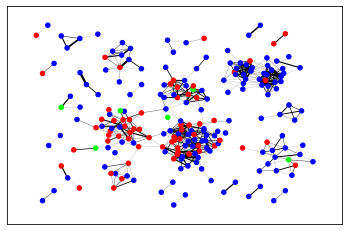

In [52]:
nx.draw_networkx(
    G = G_bt_snapshot1, 
    pos = pos_bt_snapshot1, 
    node_size = 20, 
    node_color = list(nx.get_node_attributes(G=G_bt_snapshot1, name='sex').values()), 
    cmap = plt.cm.brg, 
    with_labels = False,
    width = [w/10 for w in nx.get_edge_attributes(G=G_bt_snapshot1, name='weight').values()]
)

plt.savefig('results/G_bt_snapshot1.pdf')
plt.savefig('results/G_bt_snapshot1.png')

## Transforming, exporting, and importing networks

#### Removing direction of edges

In [53]:
D_sms_week1_lcc.to_undirected()

In [54]:
def weighted_digraph_to_graph(G, layered, fun, reciprocal, weight='weight'):
    '''
    Transforms a weighted directed graph into a weighted undirected network.
    
    Parameters:
        G : DiGraph or MultiDiGraph
            Directed network to be transformed.
        layered : Boolean
            Whether or not G is a MultiDiGraph.
        fun : String
            Function how edge weights from two edge directions are treated mathematically. Valid functions are 'mean', 'sum', and 'max'.
        reciprocal : Boolean
            If True only keep edges that appear in both directions in the original DiGraph.
        weight : String, default 'weight'
            Name of edge attribute.
    
    Returns:
        A weighted Graph.
    '''
    G = G.copy()
    
    for u, v, data in G.edges(data=True):
        data['diweight'] = data.pop(weight)
    
    if layered:
        for node in G:
            for neighbor in nx.neighbors(G, node):
                for key in G[node][neighbor].keys():
                    if node in nx.neighbors(G, neighbor):
                        if key in G[neighbor][node].keys():
                            if fun == 'mean':
                                G.edges[node, neighbor, key][weight] = (G.edges[node, neighbor, key]['diweight'] + G.edges[neighbor, node, key]['diweight']) / 2
                            elif fun == 'sum':
                                G.edges[node, neighbor, key][weight] = (G.edges[node, neighbor, key]['diweight'] + G.edges[neighbor, node, key]['diweight'])
                            elif fun == 'max':
                                G.edges[node, neighbor, key][weight] = max(G.edges[node, neighbor, key]['diweight'], G.edges[neighbor, node, key]['diweight'])
                            else:
                                raise NotImplementedError("Valid functions are 'mean', 'sum', and 'max'.")
                    else:
                        G.edges[node, neighbor, key][weight] = G.edges[node, neighbor, key]['diweight']
    else:
        for node in G:
            for neighbor in nx.neighbors(G, node):
                if node in nx.neighbors(G, neighbor):
                    if fun == 'mean':
                        G.edges[node, neighbor][weight] = (G.edges[node, neighbor]['diweight'] + G.edges[neighbor, node]['diweight']) / 2
                    elif fun == 'sum':
                        G.edges[node, neighbor][weight] = (G.edges[node, neighbor]['diweight'] + G.edges[neighbor, node]['diweight'])
                    elif fun == 'max':
                        G.edges[node, neighbor][weight] = max(G.edges[node, neighbor]['diweight'], G.edges[neighbor, node]['diweight'])
                    else:
                        raise NotImplementedError("Valid functions are 'mean', 'sum', and 'max'.")
                else:
                    G.edges[node, neighbor][weight] = G.edges[node, neighbor]['diweight']
    
    for u, v, data in G.edges(data=True):
        del data['diweight']
    
    G = G.to_undirected(reciprocal=reciprocal)
    
    return G

In [55]:
G_sms_week1_lcc = weighted_digraph_to_graph(G=D_sms_week1_lcc, layered=False, fun='mean', reciprocal=False, weight='weight')
G_sms_week1_lcc

#### Exporting

In [56]:
#nx.write_gexf(G=D_sms_week1_lcc, path='results/D_sms_week1_lcc.gexf')

In [57]:
#nx.read_gexf(path='results/D_sms_week1_lcc.gexf')

In [58]:
#nx.write_gml(G=D_sms_week1_lcc, path='results/D_sms_week1_lcc.gml', stringizer=str)

In [59]:
#nx.read_gml(path='results/D_sms_week1_lcc.gml')

In [60]:
import pickle

In [61]:
with open('results/D_sms_week1_lcc.pickle', 'wb') as f:
    pickle.dump(D_sms_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)

In [62]:
with open('results/D_sms_week1_lcc.pickle', 'rb') as f:
    _ = pickle.load(f)
_

In [63]:
with open('results/G_sms_week1_lcc.pickle', 'wb') as f:
    pickle.dump(G_sms_week1_lcc.copy(), f, pickle.HIGHEST_PROTOCOL)
with open('results/G_bt_snapshot1.pickle', 'wb') as f:
    pickle.dump(G_bt_snapshot1.copy(), f, pickle.HIGHEST_PROTOCOL)